### Training

In [1]:
%load_ext autoreload
%autoreload 2
import cProfile
import re

In [2]:
from diffmd.solvers import odeint_adjoint
from diffmd.utils import compute_grad
from diffmd.utils import quatquat, quatvec, vecquat, body_to_lab_frame, lab_to_body_frame, quat_to_euler_angles, normalize_quat, quat_rotation
from data.reader import Reader
from diffmd.diffeqs import ODEFunc


import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
import shutil
# TODO: fix quaternion module warning because of NUMBA
import quaternion
# from torchviz import make_dot # visualize computation graphs

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
print(torch.cuda.is_available())
print(f'Using {device} device')

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.log(val)
    
    def log(self, val):
        self.losses.append(val)


True
Using cuda device


Found timestep: 1e-05, n of run steps: 1000000, and dump log freq: 100


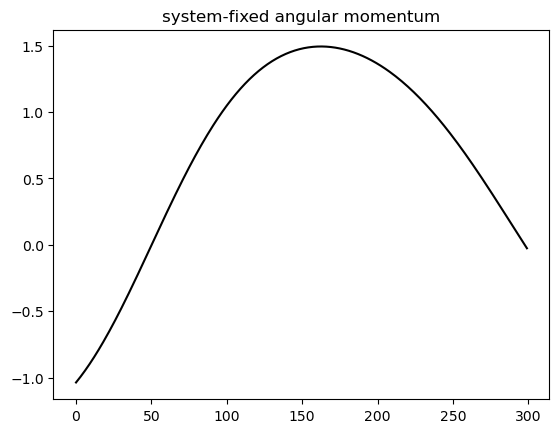

In [13]:
# prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
# file_name = prefix+'NVE-temp-1.5_K-0.0272108843537415_r-0_s-5'

prefix = 'hexagons/trajectories/smooth/'
file_name = prefix+'NVE-temp-0.45_K-0.090702947845805_r-0_s-5'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)

def get_data(file_name):
    # train_split = 0.9
    # test_split = 1 - train_split
    df = pd.read_csv(file_name+'-reduced_traj.csv')
    # HACK: do this based on the column names, not explicitly
    com = ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]'] #, 'c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']
    q = ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', 'c_q_1[4]'] #, 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']
    vel = ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]'] #, 'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]'] 
    av = ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]'] # , 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']
    am = ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]'] #, 'c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']
    inertia = ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]'] #, 'c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']
    
    centre_of_masses = df.loc[:, ['timestep', *com]]
    quaternions = df.loc[:, ['timestep', *q]]
    velocities = df.loc[:, ['timestep', *vel]]
    ang_velocities = df.loc[:, ['timestep', *av]]
    ang_momenta = df.loc[:, ['timestep', *am]]
    # inertia = df.loc[0, ['timestep', *inertia]]
    inertia = df.loc[:, ['timestep', *inertia]]
    # TODO: use DataLoaders?
    
    # trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    # split_index = int(trajs.shape[0] * train_split)

    # np.random.shuffle(trajs)
    # training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    # testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
com = centre_of_masses.iloc[:, 1:4].to_numpy()
vel = velocities.iloc[:, 1:4].to_numpy()
quats = quaternions.iloc[:, 1:5].to_numpy()
ang_momenta = ang_momenta.iloc[:, 1:4].to_numpy()
# use phase space to plot how far we are?
end_index = 1000
plt.title('system-fixed angular momentum')
plt.plot(ang_momenta[0:end_index, 0], 'k')
plt.savefig('system-fixed-angular-momentum.png')
plt.show()
# plt.plot(quats[:, 0])
# plt.plot(quats[:, 1])
# plt.plot(quats[:, 2])
# plt.plot(quats[:, 3])
# plt.plot(ang_momenta[:, 0])
# plt.plot(ang_momenta[:, 1])
# plt.plot(ang_momenta[:, 2])

# plt.show()
# trajectory = process_data(centre_of_masses, quaternions, velocities, ang_velocities, inertia)
# ang_vel = trajectory[1].cpu().detach().numpy()
# plt.plot(ang_vel[0, :, 0, :], 'r')
# plt.plot(ang_vel[0, :, 1, :], 'b')

# plt.show()


In [76]:
from diffmd.solvers import odeint_adjoint

if os.path.exists('temp'):
    shutil.rmtree('temp')

if not os.path.exists('temp'):
    os.makedirs('temp')

# prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
# file_name = prefix+'NVE-temp-0.45_K-0.090702947845805_r-0_s-5'

prefix = 'hexagons/trajectories/smooth/'
file_name = prefix+'NVE-temp-0.45_K-0.090702947845805_r-0_s-5'



niters = 2000
nn_width = 50
nn_depth = 1
learning_rate = [1]#[1.0, 0.1, 0.01, 0.001]
nparticles = 2 # trajectory[2].shape[0] ? 
batch_size = 800
batch_length = 4
# HACK: read logging frequency from file and then make dt = dt * log_freq
log_freq = reader.log_frequency
time_step = reader.timestep
dt = time_step * log_freq

losses_log = []

def main():
    for lr in learning_rate:
        loss_meter = RunningAverageMeter()
        # HACK: harmonic constant - 0.090702947845805
        func = ODEFunc(nparticles, inertia, 0.090702947845805, dim, nn_width, nn_depth).to(device)
        optimizer = torch.optim.Adam(func.parameters(), lr=lr)
        loss_function = nn.MSELoss()
        
        for itr in range(1, niters + 1):
            start = time.perf_counter()
            # zero out gradients with less memory operations
            for param in func.parameters():
                param.grad = None
            
            # HACK: to try sending in a trajectory
            batch_t, batch_y0, batch_y = get_batch_mod(trajectory, batch_size, batch_length, dt)   
            
            # TODO: add assertion to check right dimensions
            pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

            pred_y = torch.cat(pred_y, dim=-1)
            batch_y = torch.swapaxes(torch.swapaxes(torch.cat(batch_y, dim=-1), 0, 2), 1, 2)

            # TODO: train only on specifics and not all of the data   
            loss = torch.mean(torch.abs(pred_y - batch_y))
            # loss = loss_function(pred_y, batch_y)
            
            loss.backward() 
            optimizer.step()
            loss_meter.update(loss.item())
            
            if itr % 100 == 0:
                with torch.no_grad():
                    batch_t, batch_y0, batch_y = get_batch_mod(trajectory, 2, 100, dt)   

                    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

                    pred_y = torch.cat(pred_y, dim=-1)            
                    batch_y = torch.swapaxes(torch.swapaxes(torch.cat(batch_y, dim=-1), 0, 2), 1, 2)
                    # print(batch_y.shape)
                    # assert 0 == 1
                    ind_vel = [0, 1, 2]
                    ind_ang = [3, 4, 5]
                    ind_pos = [6, 7, 8]
                    ind_quat = [9, 10, 11, 12]
                    for i in ind_vel:
                        plt.title('velocities')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_vel1.png')
                    plt.close()
                    for i in ind_vel:
                        plt.title('velocities')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,1,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,1,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_vel2.png')
                    plt.close()
                    for i in ind_ang:
                        plt.title('angular velocities')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_angvel1.png')
                    plt.close()
                    for i in ind_ang:
                        plt.title('angular velocities')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,1,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,1,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_angvel2.png')
                    plt.close()
                    for i in ind_pos:
                        plt.title('positions')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_pos1.png')
                    plt.close()
                    for i in ind_pos:
                        plt.title('positions')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,1,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,1,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_pos2.png')
                    plt.close()
                    for i in ind_quat:
                        plt.title('quaternions')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_quat1.png')
                    plt.close() 
                    for i in ind_quat:
                        plt.title('quaternions')
                        plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,1,0,i], 'k--', alpha=0.3, label=f'true {i}')
                        plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,1,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                    plt.savefig(f'temp/{itr}_quat2.png')
                    plt.close() 

            if itr % 10 == 0: # output log throughout
                print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
                print('current loss: {:.4f}'.format(loss_meter.val))
                print('Last iteration took:     ', time.perf_counter() - start)

        print('========================================================')
            
        losses_log.append(loss_meter.losses)

if __name__ == '__main__':
    # cProfile.run('main()')
    main()

[autoreload of diffmd.training failed: Traceback (most recent call last):
  File "/home/jakub/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/jakub/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/jakub/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/jakub/coarsegrained-md-neural-ode/diffmd/training.py", line 3, in <module>
    from data.training import get_data, process_data, process_inertia
ImportError: cannot import name 'get_data' from 'data.training' (/home/jakub/coarsegrained-md-neural-ode/data/training.py)
]


torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])
torch.Size([800, 1])
torch.Size([800, 9])


KeyboardInterrupt: 

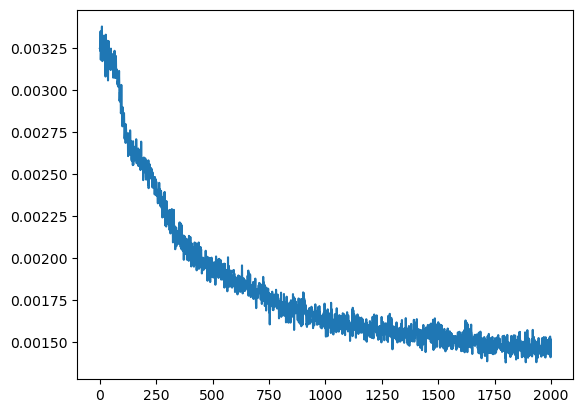

In [15]:
plt.plot(losses_log[0])
plt.show()

In [2]:
import torch
from diffmd.training import Trainer


prefix = 'hexagons/trajectories/smooth/'
dataset = 'NVE-temp-0.45_K-0.090702947845805_r-0_s-5'
config = dict(
    filename = prefix+dataset, 
    device = torch.device("cuda"), 
    niters = 10,
    optimizer = 'Adam',
    batch_length=20,
    nbatches=800,
    learning_rate=0.1,
    nn_depth=1,
    nn_width=20,
    activation_function=None,
)

trainer = Trainer(config)
model, train_loss = trainer.train()
trainer.save()


Using cuda device
Found timestep: 1e-05, n of run steps: 1000000, and dump log freq: 100


In [22]:
print(batch_y.cpu().numpy()[:,0,0,0:3])
v = batch_y.cpu().numpy()[:,0,0,0:3]
print(np.linalg.norm(v[0] - v[1]))

[[ 0.330807    0.466561   -0.539575  ]
 [-0.501856    0.229824   -0.31557   ]
 [ 0.469263    0.00821721  0.360321  ]
 [-0.27629     0.1167     -0.223378  ]
 [ 0.41892    -0.00477013  0.370613  ]
 [ 0.294175    0.740057    0.0249534 ]
 [ 0.444888    0.106165   -0.642416  ]
 [ 0.469263    0.00821721  0.360321  ]
 [-0.313959    0.332104   -0.614065  ]
 [ 0.402951    0.186684   -0.336445  ]
 [ 0.0207267   0.565495    0.0687283 ]
 [-0.308562   -0.241897   -0.120791  ]
 [-0.0624816  -0.38196     0.383526  ]
 [-0.609905    0.486766   -0.397031  ]
 [-0.475348   -0.0299944  -0.309344  ]
 [ 0.431189    0.218114   -0.594781  ]
 [ 0.690777    0.209635    0.202027  ]
 [-0.0624816  -0.38196     0.383526  ]
 [ 0.371419    0.00464408 -0.341709  ]
 [ 0.543647    0.251389    0.394125  ]]
0.8941757762112548


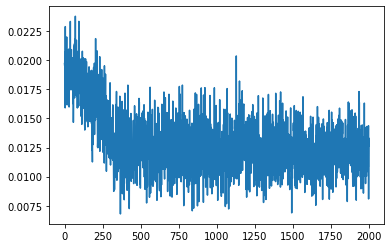

In [24]:
plt.plot(losses_log[0])

In [ ]:
from diffmd.solvers import odeint_adjoint

prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
file_name = prefix+'NVE-temp-1.5_K-0.0272108843537415_r-0_s-5'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

niters = 10
nn_width = 50
nn_depth = 3
learning_rate = 1e-1
nparticles = 2 # trajectory[2].shape[0] ? 
batch_size = 10
batch_length = 10

# Trying to learn dynamics only from centre of masses
quats = torch.zeros_like(trajectory[3])
quats[:, :, :, -1] = 1
trajectory = (trajectory[0], torch.zeros_like(trajectory[1]), trajectory[2], quats)

# Trying to learn on tenth of the trajectory
traj_length = trajectory[0].shape[1]
trajectory = (trajectory[0][:, :traj_length // 10, :, :], trajectory[1][:, :traj_length // 10, :, :], trajectory[2][:, :traj_length // 10, :, :], trajectory[3][:, :traj_length // 10, :, :])
print(trajectory[0].shape)

loss_meter = RunningAverageMeter()
# dim = nparticles * ((trajectory[2].size()[-1]) + (trajectory[3].size()[-1])) # add number of quaternions and centre of masses degrees of freedom
dim = nparticles * (3 + 3)
func = ODEFunc(nparticles, inertia, dim, nn_width, nn_depth).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()

    # HACK: to try sending in a trajectory
    batch_t, batch_y0, batch_y = get_batch_mod(trajectory, batch_size, batch_length, 0.0005)
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    pred_y = torch.cat(pred_y, dim=-1)
    batch_y = torch.cat(batch_y, dim=-1).view(pred_y.shape)
    
    # TODO: train only on specifics and not all of the data
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 250 == 0:
        with torch.no_grad():
            for i in range(6):
                plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', label=f'pred {i}')
            plt.show()

    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)

Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 10000


RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasDgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [95]:
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()

In [ ]:
print(trajectory)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01518218, -0.0139471 ,  0.01710846, ..., -0.0215073 ,
        -0.0290482 , -0.00088951],
       [-0.02682069,  0.0195529 , -0.06787774, ..., -0.173707  ,
        -0.0441775 , -0.0367169 ],
       ...,
       [-0.0213354 ,  0.277402  , -0.0801334 , ...,  0.099064  ,
         0.111093  ,  0.0802596 ],
       [-0.0109809 ,  0.315444  , -0.1316132 , ...,  0.0687512 ,
         0.115968  ,  0.0391946 ],
       [ 0.0974403 ,  0.292485  , -0.0782197 , ...,  0.00388676,
         0.0939857 , -0.0465734 ]]), array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.44322943e+00,  9.99824108e-01, -4.29189831e-03,
        -1.81224667e-02, -2.07064793e-03],
       [ 2.42378183e+00,  9.99116925e-01, -4.32879377e-03,
        -3.99009689e-02,  1.23820525e-02],
       ...,
       [ 6.38621611e+00, -7.11082596e-01,  4.32012695e-01,
        

    index  timestep  body_id    id         x         y         z
0      28    1000.0      1.0   1.0  0.989920  0.005859 -0.020850
1      29    1000.0      1.0   2.0  0.495232  0.874905 -0.014301
2      30    1000.0      1.0   3.0 -0.504460  0.881011  0.009731
3      31    1000.0      1.0   4.0 -1.009460  0.018072  0.027215
4      32    1000.0      1.0   5.0 -0.514776 -0.850974  0.020666
5      33    1000.0      1.0   6.0  0.484916 -0.857080 -0.003366
6      34    1000.0      1.0   7.0 -0.009772  0.011965  0.003183
7      35    1000.0      2.0   8.0  2.005380  1.006250  2.004160
8      36    1000.0      2.0   9.0  1.503160  1.870960  1.996230
9      37    1000.0      2.0  10.0  0.503239  1.868330  1.984050
10     38    1000.0      2.0  11.0  0.005532  1.000990  1.979800
11     39    1000.0      2.0  12.0  0.507748  0.136286  1.987730
12     40    1000.0      2.0  13.0  1.507670  0.138914  1.999910
13     41    1000.0      2.0  14.0  1.005450  1.003620  1.991980
          x         y
0  

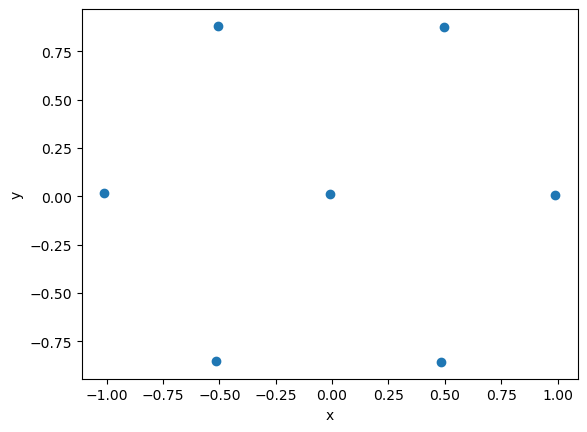

In [ ]:
firstStep = orig_traj.loc[orig_traj['timestep'] == 1000].reset_index()
firstHexagon = firstStep.loc[:6, ['x', 'y']]
print(firstStep)
print(firstHexagon)
plt.plot(firstHexagon.iloc[:, 0], firstHexagon.iloc[:, 1], 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
ang_vel_1 = ang_velocities.iloc[:, 0:3].to_numpy()
ang_mom_1 = ang_momenta.iloc[:, 0:3].to_numpy()
# print(ang_vel_1)
# print(ang_mom_1)

inertia_1 = ang_mom_1[1:, :] / ang_vel_1[1:, :]
# for i in range(100):
    # print(inertia_1[i])

# quaternion vectors are normalised
# print(np.linalg.norm(quat1[:, 1:], axis=1))



# quaternion package
# print(quat1.shape)
quat1 = quaternion.as_quat_array(quat1)
# print(quat1[0])
# print(quaternion.as_rotation_matrix(quat1)[0])
q = quat1[0]
R = quaternion.as_rotation_matrix(quat1)[0]
# print(q)
vector1 = np.array([2.5, 3.6, 3.7])
vector1_Q = np.quaternion(0, 2.5, 3.6, 3.7)
vector2_R = R @ vector1
vector2_Q = q * vector1_Q * q.conjugate()


# print(q)
# print(q.conjugate())
# print(R.shape)

print(vector2_Q)
print(quaternion.as_float_array(vector2_Q))


vector_plot([vector1, vector2_R, quaternion.as_float_array(vector2_Q)[1:]])




quaternion(6.93889390390723e-18, -2.38796216413147, -3.63768324282903, 3.73695904748035)
[ 6.93889390e-18 -2.38796216e+00 -3.63768324e+00  3.73695905e+00]


In [ ]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
quats = quaternion.as_quat_array(quat1[:10])
# consider quaternions to be a rotation from x axis
vector = np.quaternion(0, 1, 0, 0)
print(vector)
vector = quats * vector * quats.conjugate()

# print(quats)
# print(quats.conjugate())
vectors = quaternion.as_float_array(vector)[:, 1:]
# plots subsequent orientations
vector_plot(list(vectors))
print(list(vectors))

quaternion(0, 1, 0, 0)


[array([-0.99969073, -0.00631347,  0.0240322 ]), array([-0.99908286,  0.00160399,  0.04277968]), array([-0.99706856,  0.02358701,  0.07279627]), array([-0.99604604,  0.03336901,  0.08234398]), array([-0.99751062,  0.04460248,  0.05461585]), array([-0.99677454,  0.07958029,  0.01032569]), array([-0.99301676,  0.11074407, -0.04067183]), array([-0.99175207,  0.09744422, -0.08325662]), array([-0.99261598,  0.07128534, -0.09814727]), array([-0.99204744,  0.09161861, -0.08629929])]


In [ ]:
def get_batch_mod(traj,batch_size,batch_length,dt):

  twice_dim = traj.size()[2]
  dim = twice_dim//2
  sampled_is = torch.randint(traj.shape[0],size = (batch_size,)).to(device)
  sampled_js = torch.randint(traj.shape[1]-batch_length,size = (batch_size,)).to(device)
  initial_time = sampled_js*dt

  batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
  qs = traj[sampled_is,sampled_js,:dim]
  ps = traj[sampled_is,sampled_js,dim:]
  pos_init = (ps, qs)
  # print('p', ps)
  # print('q', qs)

  sampled_trajs = []

  for i in range(batch_size):
      qs = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:dim].view(-1,dim)
      ps = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,dim:].view(-1,dim)
      x = torch.cat((ps, qs), dim=1)
      sampled_trajs.append(x)

      
  batch_trajs = torch.stack(sampled_trajs,dim=1)
  return batch_t,pos_init,batch_trajs
     

def get_data():
    train_split = 0.9
    test_split = 1 - train_split
    trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    split_index = int(trajs.shape[0] * train_split)

    np.random.shuffle(trajs)
    training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return training_trajs, testing_trajs 

def train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width):    
    loss_meter = RunningAverageMeter()
    dim = training_trajs.size()[2] // 2
    func = ODEFunc(dim, nn_width, nn_depth).to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

    for itr in range(1, niters + 1):
        start = time.perf_counter()
        optimizer.zero_grad()
        
        batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, batch_size, sample_length,dt)
        
        # convert momentum to velocity (v = p / mu)
        batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
        pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

        # convert velocity to momentum (p = mu * v)
        pred_y = (pred_y[0] * func.mass, pred_y[1])
        pred_y = torch.cat(pred_y, dim=2)
        
        loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
        loss.backward() 
        optimizer.step()
        loss_meter.update(loss.item())
        
        if itr % 10 == 0: # output log throughout
            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
            print('current loss: {:.4f}'.format(loss_meter.val))
            print('Last iteration took: ', time.perf_counter() - start)

    return func, loss_meter

def test_model(func, testing_trajs, dt):    
    loss_meter = RunningAverageMeter()
    batch_size = testing_trajs.shape[0]
    sample_length = testing_trajs.shape[1]
    batch_t, batch_y0, batch_y = get_first_batch(testing_trajs, batch_size, sample_length, dt)
        
    # convert momentum to velocity (v = p / mu)
    batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    # convert velocity to momentum (p = mu * v)
    pred_y = (pred_y[0] * func.mass, pred_y[1])
    pred_y = torch.cat(pred_y, dim=2)
    
    loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
    loss_meter.update(loss.item())
    
    return loss_meter

def evaluate_model(sample_length, batch_size, learning_rate, nn_depth, nn_width, activation_function):
    niters = 300
    dt = 0.1
    t0 = time.perf_counter()

    training_trajs, testing_trajs = get_data()
    model, train_loss = train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width)
    training_time = time.perf_counter() - t0

    test_loss = test_model(model, testing_trajs, dt)

    training_and_testing_time = time.perf_counter() - t0
    return train_loss, test_loss, training_time, training_and_testing_time


import sigopt

def run_and_track_in_sigopt():

#   sigopt.log_dataset(DATASET_NAME)
#   sigopt.log_metadata(key="Dataset Source", value=DATASET_SRC)
#   sigopt.log_metadata(key="Feature Eng Pipeline Name", value=FEATURE_ENG_PIPELINE_NAME)
#   sigopt.log_metadata(
#     key="Dataset Rows", value=features.shape[0]
#   )  # assumes features X are like a numpy array with shape
#   sigopt.log_metadata(key="Dataset Columns", value=features.shape[1])
#   sigopt.log_metadata(key="Execution Environment", value="Colab Notebook")
  sigopt.log_model('Neural ODE Simple Harmonic Motion')
  learning_rates = [10**i for i in range(-5, 1)]
  sigopt.params.setdefaults(
    sample_length=np.random.randint(low=3, high=50),
    batch_size=np.random.randint(low=10, high=1000),
    learning_rate=np.random.choice(learning_rates),
    nn_depth=np.random.randint(low=1, high=5),
    nn_width=np.random.randint(low=2, high=50),
    # activation_function=,  
  )

  args = dict(
    sample_length=sigopt.params.sample_length,
    batch_size=sigopt.params.batch_size,
    learning_rate=sigopt.params.learning_rate,
    nn_depth=sigopt.params.nn_depth,
    nn_width=sigopt.params.nn_width,
    activation_function=None,
  )

  train_loss, test_loss, training_time, training_and_validation_time = evaluate_model(**args)

  running_avg_train_loss = train_loss.avg
  running_avg_test_loss = test_loss.avg

  sigopt.log_metric(name="train_loss", value=running_avg_train_loss)
  sigopt.log_metric(name="test_loss", value=running_avg_test_loss)
  sigopt.log_metric(name="training time (s)", value=training_time)
  sigopt.log_metric(name="training and validation time (s)", value=training_and_validation_time)

run_and_track_in_sigopt()

In [ ]:
import matplotlib.pyplot as plt
prefix = 'hexagons/trajectories/dump_2303/'
file_name = prefix+'NVE-temp-0.2_K-0.493827160493827_r-0_s-5'
# prefix = 'hexagons/trajectories/inertia_issue/'
# file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'
end_index = 100

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

quat_1 = quaternions.loc[:, ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', "c_q_1[4]"]].to_numpy()
# ang_vel_1 = ang_velocities.loc[:, ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]']].to_numpy()
ang_mom_1 = ang_momenta.loc[:, ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]']].to_numpy()
ang_mom_2 = ang_momenta.loc[:, ['c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']].to_numpy()
inertia_1 = inertia.loc[0, ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]']].to_numpy()
inertia_2 = inertia.loc[0, ['c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']].to_numpy()
# print(inertia_1)
# print(inertia_2)
# print(ang_mom_1)
# print(ang_mom_1**2 / 2 * inertia_1)
E_k_1 = np.sum(ang_mom_1**2 / 2 * inertia_1, axis=1) 
E_k_2 = np.sum(ang_mom_2**2 / 2 * inertia_2, axis=1)

# Plot energy
plt.plot(E_k_1[:end_index], label='E_k_1')
plt.plot(E_k_2[:end_index], label='E_k_2')
plt.legend()
plt.show()


# # Plot each column of inertia_1 as a separate line
plt.plot(ang_mom_1[:end_index, 0], 'r', label='angmom_x')
plt.plot(ang_mom_1[:end_index, 1], 'g', label='angmom_y')
plt.plot(ang_mom_1[:end_index, 2], 'b', label='angmom_z')
plt.legend()
plt.show()

In [54]:
r = np.load('wtf_r.npy')
x = np.load('wtf_x.npy')
print(r.shape)
print(x.shape)
indices = np.argwhere(np.isnan(r))
print(indices)
for i in indices:
    print('===')
    # print('BOTH ATOMS', x[:, 0, :])
    # print('===')
    print(i)
    a = x[0, i[0], :].squeeze()
    b = x[1, i[0], :].squeeze()
    print(a, b)
    print(np.linalg.norm(a - b))
    

(400, 3)
(2, 400, 3)
[[212   0]
 [212   1]
 [212   2]
 [213   0]
 [213   1]
 [213   2]
 [352   0]
 [352   1]
 [352   2]
 [353   0]
 [353   1]
 [353   2]]
===
[212   0]
[38.2092  48.0992  -9.61882] [38.2092  48.0992  -9.61882]
0.0
===
[212   1]
[38.2092  48.0992  -9.61882] [38.2092  48.0992  -9.61882]
0.0
===
[212   2]
[38.2092  48.0992  -9.61882] [38.2092  48.0992  -9.61882]
0.0
===
[213   0]
[38.468   49.1537  -9.63282] [38.468   49.1537  -9.63282]
0.0
===
[213   1]
[38.468   49.1537  -9.63282] [38.468   49.1537  -9.63282]
0.0
===
[213   2]
[38.468   49.1537  -9.63282] [38.468   49.1537  -9.63282]
0.0
===
[352   0]
[36.1959  43.0231  -5.16176] [36.1959  43.0231  -5.16176]
0.0
===
[352   1]
[36.1959  43.0231  -5.16176] [36.1959  43.0231  -5.16176]
0.0
===
[352   2]
[36.1959  43.0231  -5.16176] [36.1959  43.0231  -5.16176]
0.0
===
[353   0]
[35.602   43.7333  -5.99043] [35.602   43.7333  -5.99043]
0.0
===
[353   1]
[35.602   43.7333  -5.99043] [35.602   43.7333  -5.99043]
0.0
===
[353  

In [66]:
from diffmd.solvers import odeint_adjoint

prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
file_name = prefix+'NVE-temp-1.5_K-0.0272108843537415_r-0_s-5'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

# Get centre of mass positions
x =  trajectory[2].cpu().detach().numpy().squeeze()
diff = x[:, 0, :] - x[:, 1, :]
norm = np.linalg.norm(diff, axis=1)
for n in norm:
    if n == 0:
        print(n)
    if n != n:
        print('NAN')

Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 10000


In [16]:
a = np.load('debugger_traj.npy')
print(a.shape)
count = 0
for i in a:
    diff = i[0, :, :] - i[1, :, :]
    norm = np.linalg.norm(diff, axis=1)
    for n in norm:
        if n == 0:
            pass
            # print(count)
            print(n)
        if n != n:
            pass
            print('NAN')
    count += 1

diff = a[0, 0, :, :] - a[0, 1, :, :]
for i in diff:
    print(i)

(1, 2, 800, 3)
0.0
0.0
[ 1.4187   4.7227  -4.33923]
[ 3.1509   5.1078  -3.24636]
[-2.8507  -5.0173   3.17461]
[-2.0579  -5.5425   4.97377]
[-0.3201  -0.0764  -0.54938]
[-0.24     -1.1287    1.479228]
[-3.1402   -6.1093    5.548886]
[-2.8149   -6.7021    4.336841]
[-0.0966  -0.3781   0.38296]
[-0.1098  -0.0658  -0.04038]
[ 2.3087    3.2387   -2.470422]
[ 0.949     3.7695   -2.937366]
[-2.3192  -3.489    2.04655]
[-0.8795  -3.3924   3.26336]
[ 6.6548  11.8663  -9.28322]
[ 4.4597  12.044   -9.16687]
[ -5.3239  -12.7314   10.73419]
[ -6.7929   -13.3352     9.379845]
[-0.8418  -0.3327  -0.01143]
[ 0.5616  -0.2698   0.47636]
[ 5.7083   11.5676   -9.129292]
[ 4.964   11.3914  -8.58671]
[ 3.8189   6.4305  -4.60853]
[ 2.5491   7.2687  -5.96236]
[-0.6698  -1.0295   1.11572]
[-0.6274  -1.7611   1.03761]
[ 0.9794   0.9341  -0.50395]
[-0.0655   1.0319  -1.01318]
[-0.1703 -0.0975 -0.0137]
[ 0.3472   0.478   -0.27994]
[ 0.9923   1.301   -1.37737]
[-0.0489   0.7285  -0.18869]
[ 0.0478   -0.6417    0.9

In [135]:
indices = torch.Tensor([2, 4, 6, 9]).type(torch.long)
tensor = torch.rand(10, 3)
print(tensor)
print(indices)

print('---')

print(tensor[indices, :])

tensor([[0.0458, 0.0145, 0.2025],
        [0.3068, 0.8348, 0.3128],
        [0.2134, 0.1175, 0.4841],
        [0.9376, 0.1471, 0.8294],
        [0.7529, 0.1250, 0.3438],
        [0.3478, 0.8077, 0.5385],
        [0.2384, 0.1358, 0.5903],
        [0.9437, 0.0866, 0.4915],
        [0.8386, 0.3353, 0.4185],
        [0.7215, 0.0844, 0.4550]])
tensor([2, 4, 6, 9])
---
tensor([[0.2134, 0.1175, 0.4841],
        [0.7529, 0.1250, 0.3438],
        [0.2384, 0.1358, 0.5903],
        [0.7215, 0.0844, 0.4550]])
